In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_digits
from sklearn import cross_validation

## 2 Loading the Dataset

In [2]:
digits = load_digits()

data         = digits['data']
images       = digits['images']
target       = digits['target']
target_names = digits['target_names']



X = data[np.logical_or(target[:] == 3, target[:] == 8)]
y = target[np.logical_or(target[:] == 3, target[:] == 8)]
#y = y.reshape((y.size, 1))
y[y==3] = 1
y[y==8] = -1

print X.shape

(357L, 64L)


### 2.1 Basic Functions

In [3]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

def gradient_i(beta, X, y):
    grad = (1 - sigmoid(y*X.dot(beta))) * (-y*X.T)
    return grad
    
def gradient(beta, X, y):
    return np.sum((np.ones(len(y)) - sigmoid(y * np.dot(X, beta)))*(-y * X.T), axis=1) / len(y)

def predict(beta, X):
    return np.sign(X.dot(beta))

def zero_one_loss(y_pred, y_gt):
    return sum(np.abs(y_pred - y_gt)) / 2.


### 2.2 Optimization Method

We chose to sample without resampling, because N is small compared to the number of iterations and therefore no sample should be picked twice.

In [151]:
def gradient_descent(X, y, **kwargs):
    T = kwargs.get('T', 10)
    tau = kwargs.get('tau', 0.001)
    beta0 = kwargs.get('beta0', np.zeros((64,)))
                
    beta_k = beta0
    for t in range(T):
        grad = gradient(beta_k, X, y)
                         
        beta_k = beta_k - tau*grad
        
        yield beta_k
        
    return

def stochastic_gradient_descent(X, y, **kwargs):
    T = kwargs.get('T', 150)
    tau = kwargs.get('tau', 0.001)
    gamma = kwargs.get('gamma', 0.0001)
    beta_k = kwargs.get('beta0', np.zeros((64,)))
    
    sample_batch = np.random.permutation(len(y))[:T]
    for t in range(T):
        sample = sample_batch[t]
        grad = gradient_i(beta_k, X[sample,:], y[sample])
        
        tau_k = tau / (1 + gamma*t)**0.75
            
        beta_k = beta_k - tau_k*grad
        
        yield beta_k
        
    return

def sg_minibatch(X, y, **kwargs):
    T = kwargs.get('T', 150)
    tau = kwargs.get('tau', 0.001)
    gamma = kwargs.get('gamma', 0.0001)
    beta_k = kwargs.get('beta0', np.zeros((64,)))
    batch_size = kwargs.get('batch_size', 10)
    
    for t in range(T):
        batch = np.random.randint(X.shape[0], size=batch_size)
        
        grad = gradient(beta_k, X[batch,:], y[batch])
        
        tau_k = tau / (1 + gamma*t)
        
        beta_k = beta_k - tau_k*grad
        
        yield beta_k
        
    return

def sg_momentum(X, y, **kwargs):
    T = kwargs.get('T', 150)
    tau = kwargs.get('tau', 0.001)
    gamma = kwargs.get('gamma', 0.0001)
    beta_k = kwargs.get('beta0', np.zeros((64,)))
    mu = kwargs.get('mu', 0.1)
    
    g_t = 0.
    
    sample_batch = np.random.permutation(len(y))[:T]
    for t in range(T):
        sample = sample_batch[t]
        
        grad = gradient_i(beta_k, X[sample,:], y[sample])
        
        tau_k = tau / (1 + gamma*t)
        
        g_t = mu*g_t + (1-mu)*grad
        beta_k = beta_k - tau_k*g_t
        
        yield beta_k
        
    return

def average_stochastic_gradient(X, y, **kwargs):
    T = kwargs.get('T', 150)
    tau = kwargs.get('tau', 0.001)
    gamma = kwargs.get('gamma', 0.0001)
    beta_t = kwargs.get('beta0', np.zeros((64,)))
    mu = kwargs.get('mu', 0.1)
    
    g_t = 0.
    
    sample_batch = np.random.permutation(len(y))[:T]
    for t in range(T):
        sample = sample_batch[t]
        tau_t = tau / (1 + gamma*t)
        
        grad = gradient_i(g_t, X[sample,:], y[sample])
        
        g_t = g_t - tau_t*grad
        beta_t = (1-mu)*beta_t + mu*g_t
        
        yield beta_t
        
    return


def stochastic_average_gradient(X, y, **kwargs):
    T = kwargs.get('T', 150)
    tau = kwargs.get('tau', 0.001)
    gamma = kwargs.get('gamma', 0.0001)
    beta_t = kwargs.get('beta0', np.zeros((64,)))

    N = X.shape[0]
    D = X.shape[1]
    
    d_t = np.zeros((D))
    d_t_i = np.zeros((N, D))
    
    sample_batch = np.random.permutation(len(y))[:T]
    for t in range(T):
        sample = sample_batch[t]
                
        d_t_i_last = d_t_i[sample].copy()
        d_t_i[sample] = gradient_i(beta_t, X[sample], y[sample])
        d_t += (d_t_i[sample] - d_t_i_last) / N
        
        tau_t = tau / (1 + gamma*t)
        beta_t -= tau_t*d_t
        
        yield beta_t
    return


def dual_coordinate_ascent(X, y, **kwargs):
    T = kwargs.get('T', 150)
    tau = kwargs.get('tau', 0.001)
    gamma = kwargs.get('gamma', 0.0001)
    beta_t = kwargs.get('beta0', np.zeros((64,)))
    
    alpha_t = np.random.rand()
    beta_t = alpha_t * np.sum(np.multiply(y, X.T).T, axis=0)
    
    sample_batch = np.random.permutation(len(y))[:T]
    for t in range(T):
        sample = sample_batch[t]
        
        alpha_tp1 = np.clip(alpha_t - y[sample]*X[sample, :].dot(beta_t) / (X[sample].dot(X[sample].T)), 
                                      a_min=0., a_max=1.)
                
        beta_t = beta_t + (alpha_tp1 - alpha_t)*y[sample]*(X[sample,:])
        alpha_t = alpha_tp1
        
        yield beta_t
        
    return

def weighted_least_squares(X, y, **kwargs):
    T = kwargs.get('T', 150)
    tau = kwargs.get('tau', 0.001)
    gamma = kwargs.get('gamma', 0.0001)
    beta_t = kwargs.get('beta0', np.zeros((64,)))
    
    
    M = X.shape[0]
    
    for t in range(T):
        z_t = X.dot(beta_t)
        V_t = np.diag(np.sqrt(1./M * sigmoid(z_t)*(np.ones(M) - sigmoid(z_t))))
        y_tilde_t = y / sigmoid(y*z_t)
        y_tilde_t = y_tilde_t.clip(-1., 1.)
        z_tilde_t = (z_t + y_tilde_t).dot(V_t)
        X_tilde_t = X.T.dot(V_t).T
        X_tilde_t = np.nan_to_num(X_tilde_t)
        
        beta_t, _, _, _ = np.linalg.lstsq(X_tilde_t, z_tilde_t)
        yield beta_t
    return
        

### 2.3 Comparison

In [152]:
# NOTE: Allgemein riesige Varianz der Ergebnisse, von daher schwierig
# zu sagen welche parameter am besten sind

In [153]:
def cv_learning_rate(method, **kwargs):

    zero_one_loss_sum = 0.
    beta = np.zeros((64,))

    cv = cross_validation.KFold(y.shape[0], n_folds=10)
    for train_index, test_index in cv:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        for beta in method(X_train, y_train, **kwargs):
            pass
        
        y_pred = predict(beta, X_test)
        zero_one_loss_sum += zero_one_loss(y_pred, y_test)
        
    return zero_one_loss_sum

#### Gradient Descent

In [154]:
best_gradient_descent = len(y), None
for tau in [0.001, 0.01, 0.1]:
    options = {'T': 10, 'tau': tau}
    loss_sum = cv_learning_rate(gradient_descent, **options)
    if loss_sum < best_gradient_descent[0]:
        best_gradient_descent = loss_sum, tau

print 'Loss_sum={} for tau={}'.format(*best_gradient_descent)

Loss_sum=17.0 for tau=0.001


#### Stochastic Gradient Descent

In [155]:
np.random.seed(1)
best_stochastic_gradient_descent = len(y), None
for tau in [0.001, 0.01, 0.1]:
    for gamma in [0.0001, 0.001, 0.01]:
        options = {'T': 150, 'tau': tau, 'gamma': gamma}
        loss_sum = cv_learning_rate(stochastic_gradient_descent, **options)
        if loss_sum < best_gradient_descent[0]:
            best_stochastic_gradient_descent = loss_sum, tau, gamma

print 'Loss_sum={} for tau={}, gamma={}'.format(*best_stochastic_gradient_descent)

Loss_sum=16.0 for tau=0.1, gamma=0.01


#### SG minibatch

In [156]:
best_SG_minibatch = len(y), None
for tau in [0.001, 0.01, 0.1]:
    for gamma in [0.0001, 0.001, 0.01]:
        options = {'T': 150, 'tau': tau, 'gamma': gamma}
        loss_sum = cv_learning_rate(sg_minibatch, **options)
        if loss_sum < best_SG_minibatch[0]:
            best_SG_minibatch = loss_sum, tau, gamma

print 'Loss_sum={} for tau={}, gamma={}'.format(*best_SG_minibatch)

Loss_sum=9.0 for tau=0.1, gamma=0.0001


#### SG momentum

In [157]:
best_SG_momentum = len(y), None
for tau in [0.001, 0.01, 0.1]:
    for gamma in [0.0001, 0.001, 0.01]:
        for mu in [0.1, 0.2, 0.3]:
            options = {'T': 150, 'tau': tau, 'gamma': gamma, 'mu': mu}
            loss_sum = cv_learning_rate(sg_momentum, **options)
            if loss_sum < best_SG_momentum[0]:
                best_SG_momentum = loss_sum, tau, gamma, mu

print 'Loss_sum={} for tau={}, gamma={}, mu={}'.format(*best_SG_momentum)

Loss_sum=13.0 for tau=0.01, gamma=0.001, mu=0.1


#### Average Stochastic Gradient

In [158]:
best_average_stochastic_gradient = len(y), None
for tau in [0.001, 0.01, 0.1]:
    for gamma in [0.0001, 0.001, 0.01]:
        for mu in [0.1, 0.2, 0.3]:
            options = {'T': 150, 'tau': tau, 'gamma': gamma, 'mu': mu}
            loss_sum = cv_learning_rate(average_stochastic_gradient, **options)
            if loss_sum < best_average_stochastic_gradient[0]:
                best_average_stochastic_gradient = loss_sum, tau, gamma, mu

print 'Loss_sum={} for tau={}, gamma={}, mu={}'.format(*best_average_stochastic_gradient)

Loss_sum=11.0 for tau=0.01, gamma=0.001, mu=0.1


#### Stochastic Average Gradient

In [159]:
best_stochastic_average_gradient = len(y), None
for tau in [0.001, 0.01, 0.1]:
    for gamma in [0.0001, 0.001, 0.01]:
        options = {'T': 150, 'tau': tau, 'gamma': gamma}
        loss_sum = cv_learning_rate(stochastic_average_gradient, **options)
        if loss_sum < best_stochastic_average_gradient[0]:
                best_stochastic_average_gradient = loss_sum, tau, gamma, mu

print 'Loss_sum={} for tau={}, gamma={}, mu={}'.format(*best_stochastic_average_gradient)

Loss_sum=21.0 for tau=0.01, gamma=0.0001, mu=0.3


#### Dual Coordinate Ascent (no free parameters)

In [160]:
options = {'T': 100, 'tau': tau, 'gamma': gamma, 'mu': mu}
loss_sum = cv_learning_rate(dual_coordinate_ascent, **options)
print 'Loss_sum={}'.format(loss_sum)

Loss_sum=19.0


#### Weighted Least Squares (again no free parameters)

In [167]:
options = {'T': 6, 'tau': tau, 'gamma': gamma, 'mu': mu}
loss_sum = cv_learning_rate(weighted_least_squares, **options)
print 'Loss_sum={}'.format(loss_sum)

Loss_sum=18.0


## Speed

C:\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
C:\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\ipykernel\__main__.py:165: RuntimeWarning: divide by zero encountered in divide


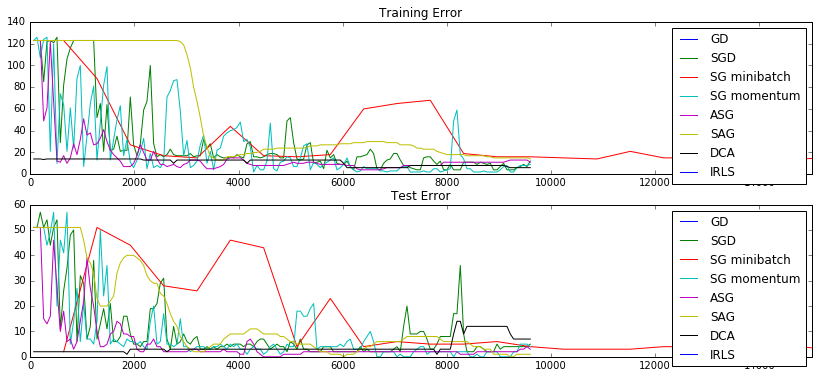

In [174]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

N = X_train.shape[0]
D = X_train.shape[1]
T_det = 10
T_stoch = 150
B = 10

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(211)
ax1.set_title('Training Error')
ax2 = fig.add_subplot(212)
ax2.set_title('Test Error')

ax1.set_xlim(0, 15e3)
ax2.set_xlim(0, 15e3)

# Gradient Descent
tau=best_gradient_descent[1]
options = {'T': T_det, 'tau': tau}
train_error = [zero_one_loss(predict(beta, X_train), y_train) for beta in gradient_descent(X_train, y_train)]
test_error = [zero_one_loss(predict(beta, X_test), y_test) for beta in gradient_descent(X_train, y_train)]

ts = np.linspace(1, T_det, T_det)*N*D
ax1.plot(ts, train_error, label='GD')
ax2.plot(ts, test_error, label='GD')


# Stochastic Gradient Descent
tau, gamma = best_stochastic_gradient_descent[1:]
options = {'tau': tau, 'gamma': gamma}
train_error = [zero_one_loss(predict(beta, X_train), y_train) for beta in stochastic_gradient_descent(X_train, y_train)]
test_error = [zero_one_loss(predict(beta, X_test), y_test) for beta in stochastic_gradient_descent(X_train, y_train)]

ts = np.linspace(1, T_stoch, T_stoch)*D
ax1.plot(ts, train_error, label='SGD')
ax2.plot(ts, test_error, label='SGD')


# SG minibatch
tau, gamma = best_SG_minibatch[1:]
options = {'tau': tau, 'gamma': gamma}
train_error = [zero_one_loss(predict(beta, X_train), y_train) for beta in sg_minibatch(X_train, y_train)]
test_error = [zero_one_loss(predict(beta, X_test), y_test) for beta in sg_minibatch(X_train, y_train)]

ts = np.linspace(1, T_stoch, T_stoch)*B*D
ax1.plot(ts, train_error, label='SG minibatch')
ax2.plot(ts, test_error, label='SG minibatch')

# SG momentum
tau, gamma, mu = best_SG_momentum[1:]
options = {'tau': tau, 'gamma': gamma, 'mu': mu}
train_error = [zero_one_loss(predict(beta, X_train), y_train) for beta in sg_momentum(X_train, y_train)]
test_error = [zero_one_loss(predict(beta, X_test), y_test) for beta in sg_momentum(X_train, y_train)]

ts = np.linspace(1, T_stoch, T_stoch)*D
ax1.plot(ts, train_error, label='SG momentum')
ax2.plot(ts, test_error, label='SG momentum')

# Average stochastic gradient
tau, gamma, mu = best_average_stochastic_gradient[1:]
options = {'tau': tau, 'gamma': gamma, 'mu': mu}
train_error = [zero_one_loss(predict(beta, X_train), y_train) for beta in average_stochastic_gradient(X_train, y_train)]
test_error = [zero_one_loss(predict(beta, X_test), y_test) for beta in average_stochastic_gradient(X_train, y_train)]

ts = np.linspace(1, T_stoch, T_stoch)*D
ax1.plot(ts, train_error, label='ASG')
ax2.plot(ts, test_error, label='ASG')

# Stochastic average gradient
tau, gamma, mu = best_stochastic_average_gradient[1:]
options = {'tau': tau, 'gamma': gamma, 'mu': mu}
train_error = [zero_one_loss(predict(beta, X_train), y_train) for beta in stochastic_average_gradient(X_train, y_train)]
test_error = [zero_one_loss(predict(beta, X_test), y_test) for beta in stochastic_average_gradient(X_train, y_train)]

ts = np.linspace(1, T_stoch, T_stoch)*D
ax1.plot(ts, train_error, label='SAG')
ax2.plot(ts, test_error, label='SAG')

# Dual Coordinate Ascent
train_error = [zero_one_loss(predict(beta, X_train), y_train) for beta in dual_coordinate_ascent(X_train, y_train)]
test_error = [zero_one_loss(predict(beta, X_test), y_test) for beta in dual_coordinate_ascent(X_train, y_train)]

ts = np.linspace(1, T_stoch, T_stoch)*D
ax1.plot(ts, train_error, label='DCA')
ax2.plot(ts, test_error, label='DCA')

# Reweighted Least Squares
train_error = [zero_one_loss(predict(beta, X_train), y_train) for beta in weighted_least_squares(X_train, y_train)]
test_error = [zero_one_loss(predict(beta, X_test), y_test) for beta in weighted_least_squares(X_train, y_train)]
ts = np.linspace(1, T_stoch, T_stoch)*N**2*D
ax1.plot(ts, train_error, label='IRLS')
ax2.plot(ts, test_error, label='IRLS')



ax1.legend()
ax2.legend()